In [1]:
using Pkg; Pkg.activate("../../NonLinearDynamicsCourse")

  Activating new environment at `~/Documents/DNL/NonLinearDynamicsCourse/Project.toml`


In [2]:
using Plots, DifferentialEquations, LinearAlgebra, Polynomials, Parameters, ForwardDiff
using BifurcationKit, Setfield, IntervalRootFinding, StaticArrays, JLD2, Interact, Interpolations
import BifurcationKit as BK

In [3]:
gr()

Plots.GRBackend()

# Analisis Parte 2
Partimos del analisis de biufurcaciones con el seguimiento de los ciclos limites correspondientes a los tres primeros modos que ya fueron calculados en la parte anterior

In [4]:
ω0=4.224 
# PARAMETROS FIJOS PARA EL MODELO DE N MODOS REAL
ωn = [1.195,2.483,3.727,4.405,5.153,6.177,6.749,7.987]
αn = [0.0176,0.0355,0.0653,0.2693,0.0703,0.166,0.0945,0.1165]
Cn = [0.1761,0.4705,0.6494,0.328,0.541,0.2249,0.3822,0.4099]
sn = -αn+1im*ωn
pc = (γ=0.4,ζ=0.6,β=1.0,ω0=ω0,Kc=100.0,s=sn,C=Cn) # Complejos
pr = (γ=0.4,ζ=0.6,β=1.0,ω0=ω0,Kc=100.0,α=αn,ω=ωn,C=Cn) # Reales
γ = @lens _.γ; # para cambiar el valor (pars es inumtable)

# N modos version real

$\dot{x} = v$

$\dot{v} = -\omega_r v + \omega_r^2 \left(\sum p_n -\gamma-x+F_c(x,v) \right)$

$\dot{p_n} = -\alpha_n p_n -2\omega_n q_n + 2C_n u\left(x, \sum p_n \right)$

$\dot{q_n} = -\alpha_n q_n + \omega_n p_n/2$

donde pusimos la dependencia la suma sobre las presiones de cada modo forma explicita y las funciones (sin regularizar):

$F_c(x,v) = K_c min(x+1,0)^2 (1 − \beta v)$    

$u\left(x, \sum p_n \right) = \zeta max(x+1,0)sign\left( \gamma-\sum p_n \right)\sqrt{\left|\gamma-\sum p_n\right|}$


In [5]:
function saxRN!(dx,x,p,t)
    @unpack γ,ζ,β,ω0,Kc,α,ω,C = p
    P = sum(x[3:2:end])
    Fc = Kc*min(real(x[1])+1,0)^2*(1-β*x[2])
    u = ζ*max(real(x[1])+1,0)*sign(γ-P)*sqrt(abs(γ-P))
    dx[1] = x[2]
    dx[2] = -ω0*x[2]+ω0^2*(P-γ-x[1]+Fc)
    for n=3:2:length(x)
        m = (n-1)÷2
        dx[n] = -α[m]*x[n]-2*ω[m]*x[n+1]+2*C[m]*u
        dx[n+1] = -α[m]*x[n+1]+0.5*ω[m]*x[n]
    end
    dx
end

saxRN! (generic function with 1 method)

In [44]:
function JsaxRn0(u, p)
	@unpack γ, ζ, β, ω0, Kc, α, ω, C = p
	P0 = sum(u[3:2:end])
	z = sqrt(γ-P0)
	nmodes = length(α)
	J0 = zeros(Float64, (2 * (nmodes+1), 2 * (nmodes+1)))
	J0[1,2] = 1.0
	J0[2,1] = -ω0 * ω0
	J0[2,2] = -ω0
	J0[2,3:2:2*nmodes+1] .= ω0 * ω0
	for n=1:nmodes
	    J0[2*n+1,1] = 2 * C[n] * ζ * z
	    J0[2*n+1,3:2:2*nmodes+1] .= -C[n] * ζ * (1- z*z)/z
	    J0[2*n+1,2*n+1] += -α[n]
	    J0[2*n+2,2*n+2] = -α[n]
	    J0[2*n+1,2*n+2] = -2*ω[n]
	    J0[2*n+2,2*n+1] = ω[n]/2.0
	end
	J0
end

JsaxRn0 (generic function with 1 method)

# Rama principal de equilibrio

Exploramos la rama principal del equilibrio de no-oscilacion sobre la cual se producen las Hopfs de los distintos modos, al menos de tres como vimos al estudiar los autovalores de este punto fijo

In [86]:
nmodes = 8
γini = 0.4
saxrn(u,p) = saxRN!(similar(u),u,p,0)
xini = vcat([-γini, 0], repeat([0.0,0.001], nmodes))
opts = ContinuationPar(pMin=γini, pMax=1.0, ds = 0.001, dsmax = 0.01, detectBifurcation=3, nInversion=8)
br1, = continuation(saxrn, JsaxRn0, xini, set(pr, γ, γini), (@lens _.γ), opts;
    recordFromSolution = (x,p) -> (x = x[1], P = sum(x[3:2:end])))
;

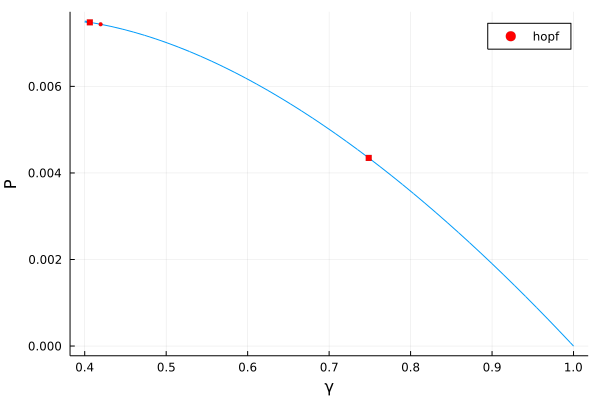

In [90]:
plot(br1,vars=(:param,:P),xlabel="γ")

#### Con las funciones regularizadas

In [ ]:
function r_saxRN!(dx,x,p,t)
	@unpack γ, ζ, β, ω0, Kc, α, ω, C = p
	P = sum(x[3:2:end])

	η = .001
	Fc = Kc * 0.5 * (x[1] + 1 - (sqrt((real(x[1]) + 1)^2 + η)))^2 * (1 - β*x[2])
	u = ζ * 0.5 * (x[1] + 1 + sqrt((real(x[1]) + 1)^2 + η)) * sign(γ - P) * sqrt(sqrt((γ - P)^2 + η))
	
	dx[1] = x[2]
	dx[2] = -ω0 * x[2] + ω0^2 * (P - γ - x[1] + Fc)
	for n=3:2:length(x)
		m = (n-1)÷2
		dx[n] = -α[m] * x[n] - 2 * ω[m] * x[n+1] + 2 * C[m] * u
		dx[n+1] = -α[m] * x[n+1] + 0.5 * ω[m] * x[n]
	end
	dx
end

r_saxRN! (generic function with 1 method)

In [96]:
nmodes = 8
γini = 0.4
saxrn(u,p) = r_saxRN!(similar(u),u,p,0)
xini = vcat([-γini, 0], repeat([0.0,0.001], nmodes))

newton_opts = NewtonPar(tol = 1e-10, maxIter = 50)

continuation_opts = ContinuationPar(pMin = γini, pMax = 1.0, ds = 0.001, dsmax = 0.01, 
	detectBifurcation = 3, nInversion = 8, newtonOptions = newton_opts)

r_br1, = continuation(saxrn, JsaxRn0, xini, set(pr, γ, γini), (@lens _.γ), continuation_opts;
	recordFromSolution = (x, p) -> (x = x[1], P = sum(x[3:2:end])))
;

┌ Error: Failure to converge with given tolerances.
└ @ BifurcationKit /Users/antonioortegabrook/.julia/packages/BifurcationKit/eoTLY/src/Predictor.jl:433


NB: ```continuation()``` devuelve el siguiente error (aunque igual produce salida) con el valor de tolerancia por defecto, que es ```1e-10```
```
┌ Error: Failure to converge with given tolerances.
└ @ BifurcationKit /Users/antonioortegabrook/.julia/packages/BifurcationKit/eoTLY/src/Predictor.jl:433
```
La tolerancia en el resultado que devuelve es 1e-2

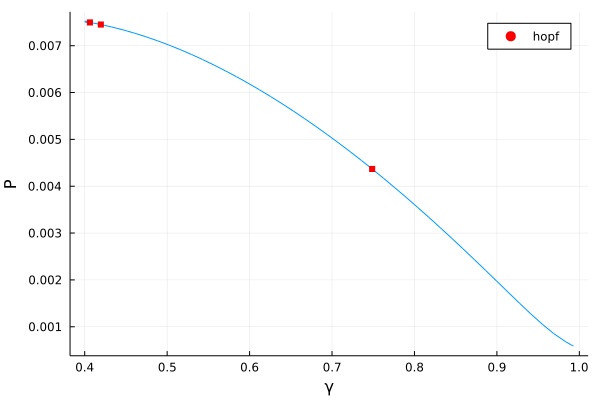

In [95]:
plot(r_br1, vars = (:param, :P), xlabel = "γ")

In [22]:
jet  = BifurcationKit.getJet(saxrn,JsaxRn0)
optn_po = NewtonPar(verbose = false, tol = 1e-8,  maxIter = 10)
norminf(x) = norm(x, Inf);

# Continuacion de CL, Modo 1 (usando Orthogonal Collocation)

Vamos a continuar la primera Hopf que como vimos es subcritica. Partimos del punto de la Hopf $\gamma=0.406$ y vamos hacia atras siguiendo el CL inestable para encontrar una SN de CL en $\gamma=0.31$ (fold). y luego avanzamos continuando el CL estable que perdura hasta $\gamma=1.0$.

In [23]:
# barrido rapido modo 1
args_po = ( recordFromSolution = (x, p) -> (xtt = BK.getPeriodicOrbit(p.prob, x,  @set pr.γ = p.p);
        return (orbit=xtt[:,:],period = getPeriod(p.prob, x, @set pr.γ = p.p))), normC = norminf)
opts_po_cont = ContinuationPar(dsmax = 0.01, ds= -0.001, dsmin = 1e-5, pMax = 1.8, pMin=0.25,
    maxSteps = 216, newtonOptions = (@set optn_po.tol = 1e-7),
    nev = 3, precisionStability = 1e-8, detectBifurcation = 0, plotEveryStep = 30, saveSolEveryStep=1);
Mt = 30 # number of time sections
br_pocoll, _, = @time continuation(jet...,br1, 1, opts_po_cont,PeriodicOrbitOCollProblem(Mt, 5, 3);
    verbosity = 0,plot = false,args_po...)

1018.612507 seconds (165.46 M allocations: 282.001 GiB, 12.69% gc time, 5.88% compilation time)


( ┌─ Branch number of points: 217
 ├─ Branch of PeriodicOrbit from Hopf bifurcation point.
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter γ starts at 0.40530438688694315, ends at 1.0128785689785391
 └─ Special points:

If `br` is the name of the branch,
ind_ev = index of the bifurcating eigenvalue e.g. `br.eig[idx].eigenvals[ind_ev]`

- #  1,  fold at γ ≈ +0.31382306 ∈ (+0.31382306, +0.31382306), |δp|=-1e+00, [    guess], δ = ( 0,  0), step =  21, eigenelements in eig[ 21], ind_ev =   0
- #  2,  fold at γ ≈ +1.74562048 ∈ (+1.74562048, +1.74562048), |δp|=-1e+00, [    guess], δ = ( 0,  0), step = 161, eigenelements in eig[161], ind_ev =   0
, BorderedArray{Vector{Float64}, Float64}([-1.0048342879287495, -0.013966195579351947, 0.004266263092987321, 0.00234753842520162, -0.002720926974195868, 0.0004308013437357731, -0.001982312440115532, -0.0004654058310042958, -0.00048388738198283453, 2.2795978767590442e-5  …  2.279597876759045e-5, -0.0002290469062603939, -0.000279504969953957, 6.7801

In [26]:
br_pocoll.eig[1]

LoadError: BoundsError: attempt to access 0-element Vector{NamedTuple{(:eigenvals, :eigenvec, :step), Tuple{Nothing, Nothing, Int64}}} at index [1]

Dado que `br_pocoll.orbit` almacena el CL que encuentra `BK.getPeriodicOrbit` durante la continuacion , podemos representar dicho ciclo límite en un espacio tridimensional usando las variables $p1$, $p2$ y $p3$ (tener en cuenta que en realidad esta orbita vive en un espacio de 18 dimensiones pero en general 3 son suficientes para no mostrar cruces. Extraemos entonces las variables y las graficamos de forma interactiva variando el parametro de control a lo largo de la rama.

In [27]:
p1=hcat(getindex.(br_pocoll.orbit,3,:)...)
p2=hcat(getindex.(br_pocoll.orbit,5,:)...)
p3=hcat(getindex.(br_pocoll.orbit,7,:)...)
@manipulate for n=1:length(br_pocoll)
    mytitle="γ="*string(br_pocoll.param[n])*"\n period="*string(br_pocoll.period[n])
    plot(p1[:,n],p2[:,n],p3[:,n],xlims=(-1.0,1.0),ylims=(-0.45,0.45),zlims=(-0.3,0.3),title=mytitle)
end    

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 217, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
109, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/antonioortegabrook/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/antonioortegabrook/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/antonioortegabrook/.julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/Users/antonioortegabrook/.julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/Users/antonioortegabrook/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000148dc5aa0, Task (runnable) @0x0000000148dc5aa0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",

# Continuacion de CL, Modo 2

In [28]:
# barrido rapido modo 2
opts_po_cont = ContinuationPar(dsmax = 0.01, ds= 0.001, dsmin = 1e-5, pMax = 1.7, pMin=0.4,
    maxSteps = 166, newtonOptions = (@set optn_po.tol = 1e-7),
    nev = 3, precisionStability = 1e-8, detectBifurcation = 0, plotEveryStep = 30, saveSolEveryStep=1);
Mt = 40 # number of time sections
br_pocoll2, _, = @time continuation(jet...,br1, 2, opts_po_cont,PeriodicOrbitOCollProblem(Mt, 5, 3);
    verbosity = 0,plot = false,args_po...)

38129.112877 seconds (127.41 M allocations: 389.551 GiB, 0.59% gc time)


( ┌─ Branch number of points: 167
 ├─ Branch of PeriodicOrbit from Hopf bifurcation point.
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter γ starts at 0.4205399520753251, ends at 1.0019731080247356
 └─ Special points:

If `br` is the name of the branch,
ind_ev = index of the bifurcating eigenvalue e.g. `br.eig[idx].eigenvals[ind_ev]`

- #  1,  fold at γ ≈ +1.59167979 ∈ (+1.59167979, +1.59167979), |δp|=-1e+00, [    guess], δ = ( 0,  0), step = 118, eigenelements in eig[118], ind_ev =   0
, BorderedArray{Vector{Float64}, Float64}([-1.8863224266322893, -8.826670637692775e-8, 0.0009826910446507798, 0.03336116100891683, 0.0012266617130841562, 0.042898554938840774, 0.0013821534027760186, 0.03944320377274724, 0.002053890034967143, 0.016797965000889058  …  0.016797965000889058, 0.0006485235572017054, 0.02376842124668345, 0.0004428006420763887, 0.008238490576934147, 0.0003590345975371584, 0.012820759562248282, 0.0003389369942972623, 0.011618405750144584, -2.986321000315041e-10], 0.9713296710

In [29]:
p1b=hcat(getindex.(br_pocoll2.orbit,3,:)...)
p2b=hcat(getindex.(br_pocoll2.orbit,5,:)...)
p3b=hcat(getindex.(br_pocoll2.orbit,7,:)...)
@manipulate for n=1:length(br_pocoll2)
    mytitle="γ="*string(br_pocoll2.param[n])*"\n period="*string(br_pocoll2.period[n])
    plot(p1b[:,n],p2b[:,n],p3b[:,n],xlims=(-0.2,0.2),ylims=(-0.6,0.6),zlims=(-0.2,0.2),title=mytitle,label="MODO2")
end    

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 167, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
84, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/antonioortegabrook/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/antonioortegabrook/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/antonioortegabrook/.julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/Users/antonioortegabrook/.julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/Users/antonioortegabrook/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000013e12e760, Task (runnable) @0x000000013e12e760), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\

In [14]:
jet  = BifurcationKit.getJet(saxrn,JsaxRn0)
optn_po = NewtonPar(verbose = false, tol = 1e-10,  maxIter = 12)
hopf3 = computeNormalForm(jet..., br1, 3;δ = 1e-10,nev = 5, Jᵗ = nothing, verbose = true, ζs = nothing)

LoadError: UndefVarError: BifurcationKit not defined

In [441]:
# barrido rapido modo 3
optn_po = NewtonPar(verbose = false, tol = 1e-8,  maxIter = 25)
opts_po_cont = ContinuationPar(dsmax = 0.01, ds=0.001, dsmin = 1e-5, pMax = 0.76, pMin=0.5,
    maxSteps = 10, newtonOptions = (@set optn_po.tol = 1e-8),
    nev = 7, precisionStability = 1e-8, detectBifurcation = 0, plotEveryStep = 30, saveSolEveryStep=1);
Mt = 40 # number of time sections
br_pocoll3, _, = @time continuation(jet...,br1, 3, opts_po_cont,PeriodicOrbitOCollProblem(Mt, 5, 3);
    verbosity = 1,plot = false,args_po...)

#####################################################
────────── Pseudo-Arclength Continuation ────────────

─────────────────  INITIAL GUESS ────────────────────
--> convergence of initial guess = OK

--> parameter = 0.7496258071259081, initial step

───────────────── INITIAL TANGENT ───────────────────
--> convergence of initial guess = OK

--> parameter = 0.7496324737925748, initial step (bis)
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 0 
Step size = 1.0000e-03
Parameter γ = 7.4963e-01 ⟶  7.4978e-01 [guess]
Parameter γ = 7.4963e-01 ⟶  7.4860e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 1 
Step size = 1.4232e-03
Parameter γ = 7.4860e-01 ⟶  7.4749e-01 [guess]
Parameter γ = 7.4860e-01 ⟶  7.4865e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 2 
Step size = 2.0255e-03
Parameter

( ┌─ Branch number of points: 11
 ├─ Branch of PeriodicOrbit from Hopf bifurcation point.
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter γ starts at 0.7496258071259081, ends at 0.7486257734806903
 └─ Special points:

If `br` is the name of the branch,
ind_ev = index of the bifurcating eigenvalue e.g. `br.eig[idx].eigenvals[ind_ev]`

- #  1,  fold at γ ≈ +0.74859642 ∈ (+0.74859642, +0.74859642), |δp|=-1e+00, [    guess], δ = ( 0,  0), step =   2, eigenelements in eig[  2], ind_ev =   0
- #  2,  fold at γ ≈ +0.74864612 ∈ (+0.74864612, +0.74864612), |δp|=-1e+00, [    guess], δ = ( 0,  0), step =   3, eigenelements in eig[  3], ind_ev =   0
- #  3,  fold at γ ≈ +0.74859611 ∈ (+0.74859611, +0.74859611), |δp|=-1e+00, [    guess], δ = ( 0,  0), step =   5, eigenelements in eig[  5], ind_ev =   0
- #  4,  fold at γ ≈ +0.74862581 ∈ (+0.74862581, +0.74862581), |δp|=-1e+00, [    guess], δ = ( 0,  0), step =   6, eigenelements in eig[  6], ind_ev =   0
, BorderedArray{Vector{Float64}, Float64}

In [454]:
bb1 = CubicSplineInterpolation(1:length(br_pocoll),br_pocoll.param)
bb2 = CubicSplineInterpolation(1:length(br_pocoll2),br_pocoll2.param)
x1=1:0.1:length(br_pocoll)
x2=1:0.1:length(br_pocoll2)
γ_list=0.3:0.01:1.75
orb1=Vector{Float64}[]
orb2=Vector{Float64}[]
for γ0 in γ_list
    f1=findall(abs.(bb1(x1).-γ0).<0.001)
    f2=findall(abs.(bb2(x2).-γ0).<0.001)
    if length(f1) >= 1
        sp1 = findall(diff(f1) .> 1)
        if !isempty(sp1)
            f1a=f1[1:sp1[1]]
            f1b=f1[sp1[1]+1:end]
            s1=[γ0,round((f1a[1]+f1a[end])/20),round((f1b[1]+f1b[end])/20)]
        else    
            s1=[γ0,round((f1[1]+f1[end])/20)]
        end    
        push!(orb1,s1)
    else
        push!(orb1,[γ0])
    end 
    if length(f2) >= 1
        sp2 = findall(diff(f2) .> 1)
        if !isempty(sp2)
            f2a=f2[1:sp2[1]]
            f2b=f2[sp2[1]+1:end]
            s2=[γ0,round((f2a[1]+f2a[end])/20),round((f2b[1]+f2b[end])/20)]
        else    
            s2=[γ0,round((f2[1]+f2[end])/20)]
        end    
        push!(orb2,s2)
    else
        push!(orb2,[γ0])    
    end 
end    

In [456]:
@manipulate for n in 1:length(γ_list)
    mytitle="γ="*string(γ_list[n])
    plt=plot(xlims=(-1,1.0),ylims=(-0.6,0.6),zlims=(-0.3,0.3),title=mytitle,size=(900,600))
    for m=2:length(orb1[n])
        idx=Int(orb1[n][m])
        plot!(plt,p1[:,idx],p2[:,idx],p3[:,idx],c=:blue,label="MODO1")
    end
    for m=2:length(orb2[n])
        idx=Int(orb2[n][m])
        plot!(plt,p1b[:,idx],p2b[:,idx],p3b[:,idx],c=:red,label="MODO2")
    end
    plt
end    

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 146, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
73, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Camilo\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Camilo\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Camilo\\.julia\\packages\\InteractBase\\h8Fwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Camilo\\.julia\\packages\\InteractBase\\h8Fwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Camilo\\.julia\\packages\\Interact\\pVyN2\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000086fb62f0, Task (runnable) @0x0000000086fb62f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\

In [24]:
Threads.nthreads()

8

In [9]:
# ATENCION NO CORRER ESTA CELDA los resultados se guardan al final
# metodo in extenso demora mucho tiempo
args_po = ( recordFromSolution = (x, p) -> (xtt = BK.getPeriodicOrbit(p.prob, x,  @set pr.γ = p.p);
        return (orbit=xtt[:,:],period = getPeriod(p.prob, x, @set pr.γ = p.p))), normC = norminf)
opts_po_cont = ContinuationPar(dsmax = 0.01, ds= -0.001, dsmin = 1e-5, pMax = 1.8, pMin=0.25,
    maxSteps = 267, newtonOptions = (@set optn_po.tol = 1e-7),
    nev = 3, precisionStability = 1e-8, detectBifurcation = 3, plotEveryStep = 30, saveSolEveryStep=1);
Mt = 30 # number of time sections
br_pocoll1, ucoll, = @time continuation(jet...,br1, 1, opts_po_cont,PeriodicOrbitOCollProblem(Mt, 5, 3);
    verbosity = 1,plot = false,args_po...)

#####################################################
────────── Pseudo-Arclength Continuation ────────────

─────────────────  INITIAL GUESS ────────────────────
--> convergence of initial guess = OK

--> parameter = 0.40530438688694315, initial step

───────────────── INITIAL TANGENT ───────────────────
--> convergence of initial guess = OK

--> parameter = 0.4052977202202765, initial step (bis)
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 0 
Step size = -1.0000e-03
Parameter γ = 4.0530e-01 ⟶  4.0450e-01 [guess]
Parameter γ = 4.0530e-01 ⟶  4.0469e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 1 
Step size = -1.3200e-03
Parameter γ = 4.0469e-01 ⟶  4.0399e-01 [guess]
Parameter γ = 4.0469e-01 ⟶  4.0388e-01 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 0.4048582477313263, δn_unstable = 1,  δn_imag = 0
───────────────────────────────────────

11-element Vector{Float64}:
     0.32804206894367094
    10.13239535163352
  5786.981911308551
  1488.9889493685575
   395.2395482176762
 36316.04300609245
     1.2923460486359704e9
     3.7796934640663296e17
     1.0486919908742638e17
     3.2071112765257384e16
     5.210256220926053e16

Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=-0.005
──────────────────────────────────────────────────────────────────────
Continuation Step 19 
Step size = -5.0000e-03
Parameter γ = 3.1437e-01 ⟶  3.1196e-01 [guess]


11-element Vector{Float64}:
 0.07726341071430215
 0.15159819170018551
 0.08479474168976214
 1.1961286583727462
 0.31256256325311893
 0.15257521206927477
 0.11161469186133466
 0.09636109764166245
 0.1159964215540163
 0.09173729306597811
 0.1485431276953619

Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=-0.0025
──────────────────────────────────────────────────────────────────────
Continuation Step 19 
Step size = -2.5000e-03
Parameter γ = 3.1437e-01 ⟶  3.1317e-01 [guess]
Parameter γ = 3.1437e-01 ⟶  3.1387e-01 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 0.31383299427064737, δn_unstable = 1,  δn_imag = 0
──────────────────────────────────────────────────────────────────────
Continuation Step 20 
Step size = -3.1125e-03
Parameter γ = 3.1383e-01 ⟶  3.1386e-01 [guess]
Parameter γ = 3.1383e-01 ⟶  3.1433e-01 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 0.31391672928284303, δn_unstable = 1,  δn_imag = 0
──────────────────────────────────────────────────────────────────────
Continuation Step 21 
Step size = -3.8751e-03
Parameter γ = 3.1392e-01 ⟶  3.1431e-01 [guess]
Parameter γ = 3.1392e-01 ⟶  3.1461e-01 
Predictor: SecantPred()
───────────────────────────────────────────────────────

Parameter γ = 5.1514e-01 ⟶  5.2669e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 50 
Step size = -1.0000e-02
Parameter γ = 5.2669e-01 ⟶  5.3821e-01 [guess]
Parameter γ = 5.2669e-01 ⟶  5.3835e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 51 
Step size = -1.0000e-02
Parameter γ = 5.3835e-01 ⟶  5.4999e-01 [guess]
Parameter γ = 5.3835e-01 ⟶  5.5007e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 52 
Step size = -1.0000e-02
Parameter γ = 5.5007e-01 ⟶  5.6176e-01 [guess]
Parameter γ = 5.5007e-01 ⟶  5.6183e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 53 
Step size = -1.0000e-02
Parameter γ = 5.6183e-01 ⟶  5.7356e-01 [guess]
Parameter γ = 5.6183e-01 ⟶  5.7356e-01 
Predictor: SecantPred()
────────────────────────

Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 80 
Step size = -1.0000e-02
Parameter γ = 7.8218e-01 ⟶  7.9467e-01 [guess]
Parameter γ = 7.8218e-01 ⟶  7.9473e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 81 
Step size = -1.0000e-02
Parameter γ = 7.9473e-01 ⟶  8.0726e-01 [guess]
Parameter γ = 7.9473e-01 ⟶  8.0734e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 82 
Step size = -1.0000e-02
Parameter γ = 8.0734e-01 ⟶  8.1994e-01 [guess]
Parameter γ = 8.0734e-01 ⟶  8.1997e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 83 
Step size = -1.0000e-02
Parameter γ = 8.1997e-01 ⟶  8.3259e-01 [guess]
Parameter γ = 8.1997e-01 ⟶  8.3266e-01 
Predictor: SecantPred()
────────────────────────────────────────────────────────────────

--> bp Bifurcation point at p ≈ 1.1109911888563775, δn_unstable = 1,  δn_imag = 0
──────────────────────────────────────────────────────────────────────
Continuation Step 109 
Step size = -1.0000e-02
Parameter γ = 1.1110e+00 ⟶  1.1228e+00 [guess]
Parameter γ = 1.1110e+00 ⟶  1.1226e+00 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 1.1135682853274391, δn_unstable = 1,  δn_imag = 0
──────────────────────────────────────────────────────────────────────
Continuation Step 110 
Step size = -1.0000e-02
Parameter γ = 1.1136e+00 ⟶  1.1253e+00 [guess]
Parameter γ = 1.1136e+00 ⟶  1.1251e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 111 
Step size = -1.0000e-02
Parameter γ = 1.1251e+00 ⟶  1.1366e+00 [guess]
Parameter γ = 1.1251e+00 ⟶  1.1364e+00 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 1.1272469578214788, δn_unstable = 1,  δn_imag = 0
───────────────────────────────────────────────────────────────────

Parameter γ = 1.3066e+00 ⟶  1.3196e+00 [guess]
Parameter γ = 1.3066e+00 ⟶  1.3197e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 137 
Step size = -1.0000e-02
Parameter γ = 1.3197e+00 ⟶  1.3328e+00 [guess]
Parameter γ = 1.3197e+00 ⟶  1.3329e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 138 
Step size = -1.0000e-02
Parameter γ = 1.3329e+00 ⟶  1.3462e+00 [guess]
Parameter γ = 1.3329e+00 ⟶  1.3462e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 139 
Step size = -1.0000e-02
Parameter γ = 1.3462e+00 ⟶  1.3595e+00 [guess]
Parameter γ = 1.3462e+00 ⟶  1.3596e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 140 
Step size = -1.0000e-02
Parameter γ = 1.3596e+00 ⟶  1.3730e+00 [guess]
Parameter γ = 1.3596e+00 ⟶  1.3730e+0

Parameter γ = 1.7363e+00 ⟶  1.7451e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 169 
Step size = -1.0000e-02
Parameter γ = 1.7451e+00 ⟶  1.7533e+00 [guess]


11-element Vector{Float64}:
 0.013433484813919802
 0.005456836656911435
 0.009417967269207406
 0.006544047866244185
 0.031378634200540656
 0.01036908328609254
 0.005741688507762355
 0.0249861930608537
 0.008825977857671141
 0.006699345441934845
 0.008143122752619192

Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=-0.005
──────────────────────────────────────────────────────────────────────
Continuation Step 169 
Step size = -5.0000e-03
Parameter γ = 1.7451e+00 ⟶  1.7492e+00 [guess]
Parameter γ = 1.7451e+00 ⟶  1.7448e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 170 
Step size = -6.2250e-03
Parameter γ = 1.7448e+00 ⟶  1.7446e+00 [guess]
Parameter γ = 1.7448e+00 ⟶  1.7399e+00 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 1.7438227555425632, δn_unstable = 1,  δn_imag = 0
──────────────────────────────────────────────────────────────────────
Continuation Step 171 
Step size = -8.2170e-03
Parameter γ = 1.7438e+00 ⟶  1.7392e+00 [guess]
Parameter γ = 1.7438e+00 ⟶  1.7368e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 172 
Step size = -1.0000e-02
Parameter γ = 1.736

──────────────────────────────────────────────────────────────────────
Continuation Step 229 
Step size = -1.0000e-02
Parameter γ = 1.0308e+00 ⟶  1.0173e+00 [guess]
Parameter γ = 1.0308e+00 ⟶  1.0174e+00 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 1.0282852413605656, δn_unstable = 1,  δn_imag = 0
──────────────────────────────────────────────────────────────────────
Continuation Step 230 
Step size = -1.0000e-02
Parameter γ = 1.0283e+00 ⟶  1.0148e+00 [guess]
Parameter γ = 1.0283e+00 ⟶  1.0148e+00 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 1.021964203729021, δn_unstable = 1,  δn_imag = 0
──────────────────────────────────────────────────────────────────────
Continuation Step 231 
Step size = -1.0000e-02
Parameter γ = 1.0220e+00 ⟶  1.0085e+00 [guess]
Parameter γ = 1.0220e+00 ⟶  1.0086e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 232 
Step size = -1.0000e-02
Parameter γ

11-element Vector{Float64}:
  0.023983424663907155
  0.05612115577861138
  0.1424274621291079
  0.138052884975825
  0.04427446190182768
  0.02203561367023844
  0.2013006273573812
  0.07494933448407248
 16.332177705075473
  4.203722820048746
  2.5127888037354955

 = 1.0086e+00 ⟶  9.9516e-01 [guess]
Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=-0.005
──────────────────────────────────────────────────────────────────────
Continuation Step 232 
Step size = -5.0000e-03
Parameter γ

11-element Vector{Float64}:
    0.00917647162761769
    0.0027293511884531572
    0.01963248638710964
    0.017857370398626934
   12.039749248973658
   35.08501808599708
 1182.6705129804639
    9.266267236860003e6
    2.4932058378510732e7
    4.589490213717216e6
    1.0205944290161291e10

 = 1.0086e+00 ⟶  1.0019e+00 [guess]
Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=-0.0025
──────────────────────────────────────────────────────────────────────
Continuation Step 232 
Step size = -2.5000e-03
Parameter γ = 1.0086e+00 ⟶  1.0052e+00 [guess]
Parameter γ = 1.0086e+00 ⟶  1.0053e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 233 
Step size = -3.1125e-03
Parameter γ = 1.0053e+00 ⟶  1.0012e+00 [guess]


11-element Vector{Float64}:
 0.005656784778627443
 0.00993209847675475
 0.04170091147431978
 0.03085707031798017
 0.014127670672247298
 0.007044838344298617
 0.010316288106245356
 0.016292960503408716
 0.0033273406120424027
 0.0035454889844760283
 0.0011344560395451647

Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=-0.00155625
──────────────────────────────────────────────────────────────────────
Continuation Step 233 
Step size = -1.5562e-03
Parameter γ

11-element Vector{Float64}:
 0.0021001699148276145
 0.03483979400631082
 0.07791534399058203
 0.04150044691193967
 0.009691008705468605
 0.003234777644473671
 0.0010482972442734805
 0.0021120129558435574
 0.0008787706373467565
 0.007195433875841666
 0.007322599912394248

 = 1.0053e+00 ⟶  1.0032e+00 [guess]
Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=-0.000778125
──────────────────────────────────────────────────────────────────────
Continuation Step 233 
Step size = -7.7812e-04
Parameter γ

11-element Vector{Float64}:
 0.0008501092426583656
 0.00026423083448248817
 0.001028089406529167
 0.00039651483461429883
 0.00028389964409205877
 0.0006003357878924031
 0.00022317313202017554
 0.0021242357257188547
 0.0007015666348163237
 0.0003294267271215649
 0.0018294460912688347

 = 1.0053e+00 ⟶  1.0043e+00 [guess]
Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=-0.0003890625
──────────────────────────────────────────────────────────────────────
Continuation Step 233 
Step size = -3.8906e-04
Parameter γ = 1.0053e+00 ⟶  1.0048e+00 [guess]
Parameter γ = 1.0053e+00 ⟶  1.0048e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 234 
Step size = -4.8438e-04
Parameter γ = 1.0048e+00 ⟶  1.0043e+00 [guess]


11-element Vector{Float64}:
 0.0004221205901288205
 0.0007616388447687626
 0.0005349953232052004
 0.13494364206189347
 0.0848534225460223
 0.26634092910165236
 0.10720234461043517
 0.046160587191006054
 1.7501060136814992
 0.6376060116822951
 0.36077320406490765

Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=-0.00024219140624999998
──────────────────────────────────────────────────────────────────────
Continuation Step 234 
Step size = -2.4219e-04
Parameter γ = 1.0048e+00 ⟶  1.0045e+00 [guess]
Parameter γ = 1.0048e+00 ⟶  1.0047e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 235 
Step size = -2.8579e-04
Parameter γ = 1.0047e+00 ⟶  1.0046e+00 [guess]
Parameter γ = 1.0047e+00 ⟶  1.0054e+00 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 1.0052935001271783, δn_unstable = 1,  δn_imag = 0
──────────────────────────────────────────────────────────────────────
Continuation Step 236 
Step size = -3.5580e-04
Parameter γ = 1.0053e+00 ⟶  1.0057e+00 [guess]
Parameter γ = 1.0053e+00 ⟶  1.0057e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 237 
Step size = -4.6966e-04
Pa

──────────────────────────────────────────────────────────────────────
Continuation Step 263 
Step size = -1.0000e-02
Parameter γ = 1.2330e+00 ⟶  1.2466e+00 [guess]
Parameter γ = 1.2330e+00 ⟶  1.2466e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 264 
Step size = -1.0000e-02
Parameter γ = 1.2466e+00 ⟶  1.2601e+00 [guess]
Parameter γ = 1.2466e+00 ⟶  1.2601e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 265 
Step size = -1.0000e-02
Parameter γ = 1.2601e+00 ⟶  1.2737e+00 [guess]
Parameter γ = 1.2601e+00 ⟶  1.2737e+00 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 266 
Step size = -1.0000e-02
Parameter γ = 1.2737e+00 ⟶  1.2872e+00 [guess]
Parameter γ = 1.2737e+00 ⟶  1.2872e+00 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 1.2838270024294465, δn_unstable = 1,  δn_imag = 0
──

( ┌─ Branch number of points: 268
 ├─ Branch of PeriodicOrbit from Hopf bifurcation point.
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter γ starts at 0.40530438688694315, ends at 1.2838270024294465
 └─ Special points:

If `br` is the name of the branch,
ind_ev = index of the bifurcating eigenvalue e.g. `br.eig[idx].eigenvals[ind_ev]`

- #  1,    bp at γ ≈ +0.40485825 ∈ (+0.40485825, +0.40485831), |δp|=6e-08, [converged], δ = (-1,  0), step =   2, eigenelements in eig[  3], ind_ev =   2
- #  2,    bp at γ ≈ +0.31383299 ∈ (+0.31382931, +0.31383299), |δp|=4e-06, [converged], δ = (-1,  0), step =  20, eigenelements in eig[ 21], ind_ev =   1
- #  3,    bp at γ ≈ +0.31391673 ∈ (+0.31386708, +0.31391673), |δp|=5e-05, [converged], δ = ( 1,  0), step =  21, eigenelements in eig[ 22], ind_ev =   1
- #  4,    bp at γ ≈ +0.37162078 ∈ (+0.36957809, +0.37162078), |δp|=2e-03, [converged], δ = (-1,  0), step =  35, eigenelements in eig[ 36], ind_ev =   1
- #  5,    bp at γ ≈ +0.65781364 ∈ (+0.6574

In [10]:
@save "modo1all.jld2" br_pocoll1

In [121]:
using Statistics
n=3
A=(br_pocoll1.orbit[n] .- mean(br_pocoll1.orbit[n],dims=2))
amp=mean([norm(A[:,i]) for i=1:size(A)[2]])

0.025487998964430606

In [138]:
λ=br_pocoll1.eig[25][1]
maximum(real.(λ))

0.020105302496631127

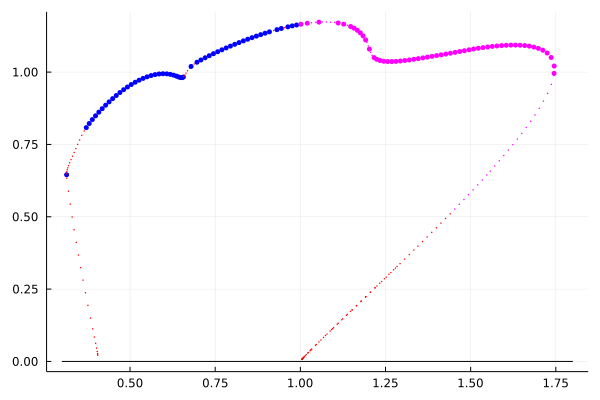

In [147]:
plt1=plot(legend=false)
plt2=plot()
for n = 1:length(br_pocoll1)
    λ=br_pocoll1.eig[n][1]
    if maximum(real.(λ))>0.0
        col = :red
        ms = 1
    else
        col = :blue
        ms = 3
    end 
    if length(λ)<18
        col = :magenta
    end    
    A=(br_pocoll1.orbit[n] .- mean(br_pocoll1.orbit[n],dims=2))
    amp=mean([norm(A[:,i]) for i=3:2:size(A)[2]])
    scatter!(plt1,[br_pocoll1.param[n]],[amp],color=col,markersize=ms,markerstrokewidth=0)
    #scatter!(plt2,fill(n,length(λ)),imag.(λ),markersize=1,markerstrokewidth=0)
    #scatter!(plt1,real.(λ),imag.(λ),color=1:length(λ),markersize=2,markerstrokewidth=0,xlims=(-3,0.6))
end
plot!(plt1,[0.3,1.8],[0,0],c=:black)
#plot(plt1,plt2,layout=(2,1))
plt1

In [ ]:
# ATENCION NO CORRER! los resultados se guardan al final
opts_po_cont = ContinuationPar(dsmax = 0.01, ds= 0.001, dsmin = 1e-4, pMax = 0.7, pMin=0.4,
    maxSteps = 110, newtonOptions = (@set optn_po.tol = 1e-7),
    nev = 3, precisionStability = 1e-8, detectBifurcation = 3, plotEveryStep = 30, saveSolEveryStep=1);
Mt = 30 # number of time sections
br_pocoll2, ucoll, = @time continuation(jet...,br1, 2, opts_po_cont,PeriodicOrbitOCollProblem(Mt, 5, 3);
    verbosity = 1,plot = false,args_po...)

## Standard Shooting